In [2]:
%pip install matplotlib scipy pandas pyarrow Jinja2

Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd

wiki_df = pd.read_csv("edit_history.txt", sep='\t', header=None, names=["Title", "Edit DateTime", "Probe DateTime"], usecols=["Title", "Edit DateTime"])
wiki_df['Edit DateTime'] = pd.to_datetime(wiki_df['Edit DateTime']) # text to datetime
# Sort the DataFrame by 'Title' and 'Edit DateTime' to ensure the deltas are calculated correctly
wiki_df.sort_values(by=['Title', 'Edit DateTime'], inplace=True)
# Calculate the time deltas for consecutive edits within the same title
wiki_df['Time Delta'] = wiki_df.groupby('Title')['Edit DateTime'].diff()
wiki_df.head()

,Title,Edit DateTime,Time Delta
31252,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:13:00,NaT
31250,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:29:00,0 days 00:16:00
31251,%C3%96nd%C3%B6r_Gongor,2008-01-27 15:29:00,0 days 00:00:00
31249,%C3%96nd%C3%B6r_Gongor,2008-01-29 13:24:00,1 days 21:55:00
31248,%C3%96nd%C3%B6r_Gongor,2008-01-29 13:25:00,0 days 00:01:00


In [4]:
# Remove rows with not-a-time (NaT) values in the 'Time Delta' column
wiki_df.dropna(subset=['Time Delta'], inplace=True)
# Sort by time delta and reset the index
wiki_df.sort_values(by='Time Delta', inplace=True)
wiki_df.reset_index(drop=True, inplace=True)
display(wiki_df)
wiki_df['Time Delta'].describe()


,Title,Edit DateTime,Time Delta
0,Kentucky_Wildcats,2023-03-31 01:54:00,0 days 00:00:00
1,Berlin_Half_Marathon,2022-11-25 10:47:00,0 days 00:00:00
2,2020_South_Carolina_Senate_election,2020-11-05 03:29:00,0 days 00:00:00
3,2020_South_Carolina_Senate_election,2020-11-05 03:28:00,0 days 00:00:00
4,2020_South_Carolina_Senate_election,2020-11-05 03:28:00,0 days 00:00:00
...,...,...,...
36315,Von_Essen_Mountain,2022-02-26 04:49:00,3575 days 12:47:00
36316,Pete_Budd,2021-06-21 16:33:00,4693 days 19:43:00
36317,WNBA_on_NBC,2022-06-05 08:44:00,4719 days 09:21:00
36318,Ardskenish,2021-09-01 04:26:00,4797 days 11:18:00


count                          36320
mean      92 days 13:46:11.116189427
std      195 days 11:36:52.016155110
min                  0 days 00:00:00
25%                  0 days 00:27:00
50%                 15 days 05:41:00
75%                100 days 21:45:45
max               4810 days 17:39:00
Name: Time Delta, dtype: object

In [5]:
def seconds_to_text(seconds):
    seconds = round(seconds)
    result = []
    for unit_name, unit_seconds in [('y', 86400 * 365.25),('d', 86400),('h', 3600),('m', 60),('s', 1)]:
        if seconds >= unit_seconds:
            unit_value, seconds = divmod(seconds, unit_seconds)
            result.append(f"{int(unit_value)}{unit_name}")
    return ' '.join(result) if result else "<1s"

seconds_to_text(100)

'1m 40s'

In [6]:

import numpy as np

def wait_wait_table(df, wait_ticks):
    sorted_time_deltas_seconds = df['Time Delta'].dt.total_seconds()
    results = []
    for wait_tick in wait_ticks:
        greater_or_equal_values = sorted_time_deltas_seconds[sorted_time_deltas_seconds >= wait_tick]
        if len(greater_or_equal_values) == 0:
            continue
        median_wait = np.median(greater_or_equal_values)
        additional_wait = median_wait - wait_tick
        results.append({"Wait So Far": seconds_to_text(wait_tick), "Median Additional Wait": seconds_to_text(additional_wait)})
    return pd.DataFrame(results)

wiki_wait_ticks = [0, 60, 60*5, 60*15, 3600, 3600*4, 86400, 86400 * 7,86400 * 30, 86400 * 100, 86400 * 365.25, 86400 * 365.25 * 5, 86400 * 365.25 * 10]
wait_tick_labels = [seconds_to_text(wait_tick) for wait_tick in wiki_wait_ticks]
wait_wait_table(wiki_df, wiki_wait_ticks).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,15d 5h 41m
1m,19d 38m
5m,34d 16h 31m
15m,41d 12h 41m
1h,47d 4h 52m
4h,52d 14h 31m
1d,61d 7h 41m
7d,76d 4h 8m
30d,95d 10h 10m
100d,122d 4h 18m


In [7]:
seed = 0
rng = np.random.default_rng(seed)
sorted_popcorn_time_deltas = np.sort(rng.normal(5*60, 15, 30_000))
popcorn_df = pd.DataFrame(pd.to_timedelta(sorted_popcorn_time_deltas,unit="s"), columns=["Time Delta"])
print(popcorn_df.describe())

                      Time Delta
count                      30000
mean   0 days 00:05:00.060355606
std    0 days 00:00:14.956424467
min    0 days 00:03:52.588244397
25%    0 days 00:04:50.011437922
50%    0 days 00:04:59.971380399
75%    0 days 00:05:10.239357827
max    0 days 00:05:59.183245298


In [8]:

wait_wait_table(popcorn_df, [0, 10, 30, 60, 2*60, 3*60, 4*60, 5*60]).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,5m
10s,4m 50s
30s,4m 30s
1m,4m
2m,3m
3m,2m
4m,1m
5m,10s


In [85]:
seed = 0
rng = np.random.default_rng(seed)
last_win_week = None
lotto_waits = []
for week in range(1_000_000):
    if rng.uniform(high=27.1) < 1.0:
        if last_win_week is not None:
            wait_seconds = (week - last_win_week) * 7 * 24 * 60 * 60
            lotto_waits.append(wait_seconds)
        last_win_week = week
sorted_lotto_waits = np.sort(np.array(lotto_waits))
lotto_df = pd.DataFrame(pd.to_timedelta(sorted_lotto_waits, unit="s"), columns=["Time Delta"])
print(lotto_df.describe())

                        Time Delta
count                        36773
mean   190 days 08:21:00.141951976
std    185 days 22:42:41.462765808
min                7 days 00:00:00
25%               56 days 00:00:00
50%              133 days 00:00:00
75%              259 days 00:00:00
max             2429 days 00:00:00


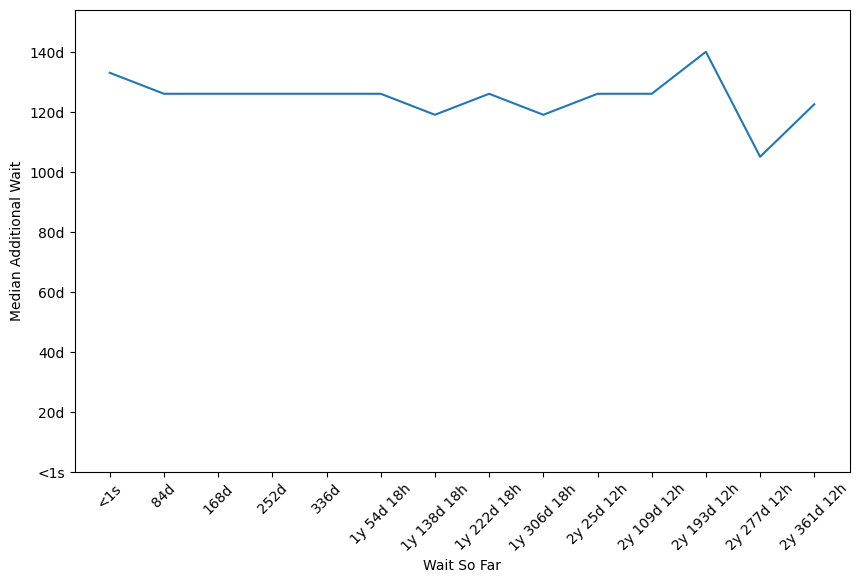

In [10]:
import matplotlib.pyplot as plt
import math

def wait_wait_plot(df, waits, wait_ticks, additional_ticks):
    sorted_time_deltas_seconds = df['Time Delta'].dt.total_seconds()
    xs = []
    ys = []
    for wait_tick in waits:
        greater_or_equal_values = sorted_time_deltas_seconds[sorted_time_deltas_seconds >= wait_tick]
        if len(greater_or_equal_values) == 0:
            continue
        median_wait = np.median(greater_or_equal_values)
        additional_wait = median_wait - wait_tick
        xs.append(wait_tick)
        ys.append(additional_wait)
        # results.append({"Wait So Far": seconds_to_text(wait_tick), "Median Additional Wait": seconds_to_text(additional_wait)})

    plt.figure(figsize=(10, 6))
    plt.xlabel('Wait So Far')
    plt.ylim(bottom=0, top=1.1 * max(ys))
    plt.ylabel('Median Additional Wait')
    wait_tick_labels = [seconds_to_text(wait_tick) for wait_tick in wait_ticks]
    plt.xticks(wait_ticks, wait_tick_labels, rotation=45)
    plt.yticks(additional_ticks, [seconds_to_text(additional_tick) for additional_tick in additional_ticks])
    # plt.grid(True, which="both", ls="--")

    plt.plot(xs, ys, marker=None, linestyle='-')

    plt.show()
    # return pd.DataFrame(results)

    # weeks_list = [1, 4, 52, 2*52, 3*52, 4*52, 5*52]
# lotto_ticks = [0] + [week * 7 * 24 * 60 * 60 + extra_second for week in weeks_list for extra_second in [0, 0.001]]
years = 3
lotto_waits = [day * 24 * 60 * 60 for day in range(365*years)]
lotto_waits = [four_week * 4 * 7 * 24 * 60 * 60 for four_week in range(0, math.ceil(365 * years / 7 / 4), years)]
lotto_additional_ticks = [day * 24 * 60 * 60 for day in range(0, 160, 20)]

wait_wait_plot(lotto_df, lotto_waits, lotto_waits, lotto_additional_ticks)

In [86]:

lotto_days = [0, 7, 7.00001,  2*7, 4*7, 183, 365.25, 2*365.25, 5*365.25]
lotto_waits = [day * 24 * 60 * 60 for day in lotto_days]
wait_wait_table(lotto_df, lotto_waits).style.hide(axis="index")

Wait So Far,Median Additional Wait
<1s,133d
7d,126d
7d 1s,132d 23h 59m 59s
14d,126d
28d,126d
183d,132d
1y,131d 18h
2y,130d 12h
5y,49d 18h


In [87]:
lotto_df[lotto_df["Time Delta"] > pd.to_timedelta(24*60*60 * 365.25 * 5, unit="s")]

,Time Delta
36770,1869 days
36771,1876 days
36772,2429 days


In [17]:
wiki_wait_ticks

[0,
 60,
 300,
 900,
 3600,
 14400,
 86400,
 604800,
 2592000,
 8640000,
 31557600.0,
 157788000.0,
 315576000.0]

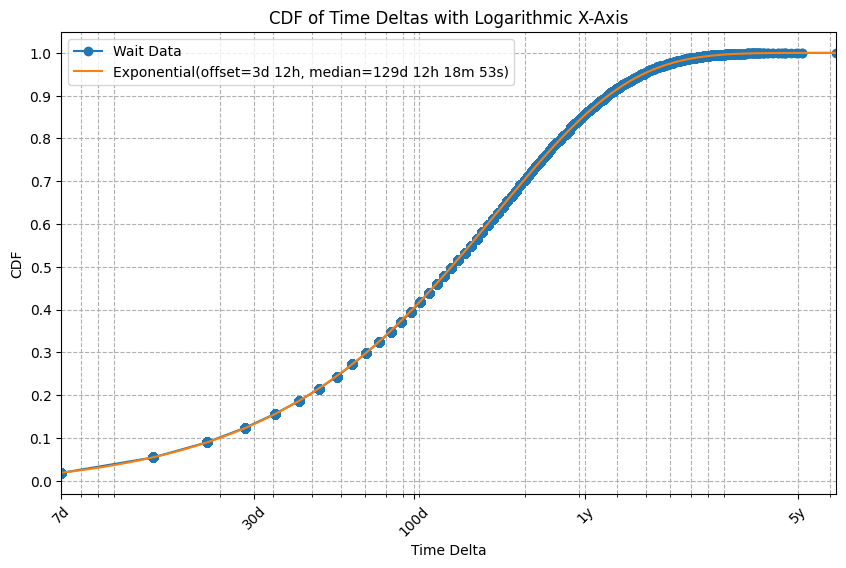

In [116]:
from scipy.stats import expon, geom

def wait_cdf(sorted_df, wait_ticks, offset=None):
    sorted_wait_series = sorted_df['Time Delta']
    wait_seconds = sorted_wait_series.dt.total_seconds()
    empirical_cdf = sorted_wait_series.rank(method='average', pct=True)  # This computes the rank as a percentage

    # plot the empirical CDF on a log scale
    plt.figure(figsize=(10, 6))
    plt.plot(wait_seconds, empirical_cdf, marker='o', linestyle=None, label='Wait Data')
    plt.xlabel('Time Delta')
    plt.ylabel('CDF')
    plt.title('CDF of Time Deltas with Logarithmic X-Axis')
    plt.xscale('log')
    plt.yticks(np.arange(0, 1.1, 0.1))
    wait_tick_labels = [seconds_to_text(wait_tick) for wait_tick in wait_ticks]
    plt.xticks(wait_ticks, wait_tick_labels, rotation=45)
    left = wait_seconds.min()
    right = wait_seconds.max()
    plt.xlim(left=left, right=right)
    plt.grid(True, which="both", ls="--")

    # fit an exponential distribution to the data
    offset, scale = expon.fit(lotto_df['Time Delta'].dt.total_seconds(),  floc=offset)
    median = scale * math.log(2)
    expon_dist = expon(loc=offset, scale=scale)
    # plot the exponential CDF
    dense_ticks = np.logspace(np.log10(left), np.log10(right), 100)
    cdf_values = expon_dist.cdf(dense_ticks)
    plt.plot(dense_ticks, cdf_values, label=f'Exponential(offset={seconds_to_text(offset)}, median={seconds_to_text(median)})')
    plt.legend()
    plt.show()

wait_cdf(lotto_df, wiki_wait_ticks, offset=7*24*60*60/2)

C:\Users\carlk\AppData\Local\Temp\ipykernel_42564\2575198512.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left=left, right=right)
C:\Users\carlk\AppData\Local\Temp\ipykernel_42564\2575198512.py:28: RuntimeWarning: divide by zero encountered in log10
  dense_ticks = np.logspace(np.log10(left), np.log10(right), 100)
c:\Users\carlk\OneDrive\programs\wait-times\.conda\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\carlk\OneDrive\programs\wait-times\.conda\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


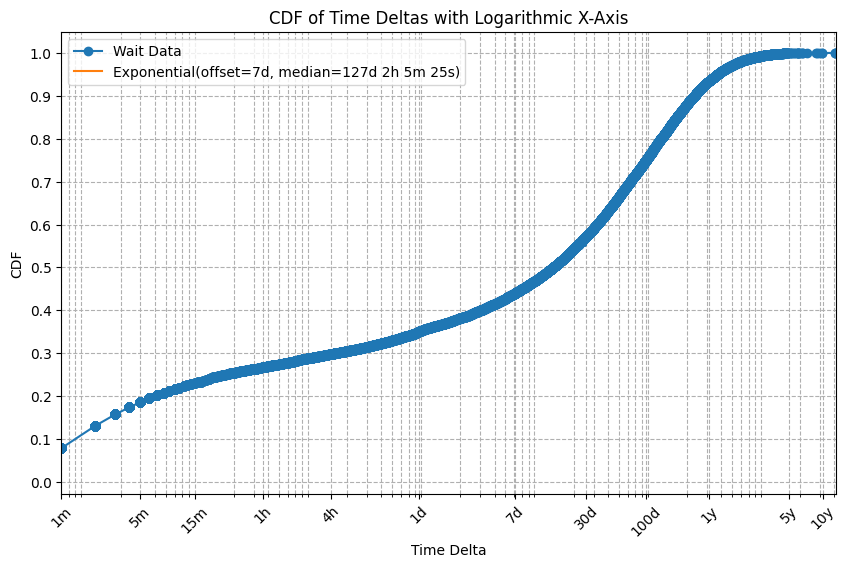

In [118]:
wait_cdf(wiki_df, wiki_wait_ticks)

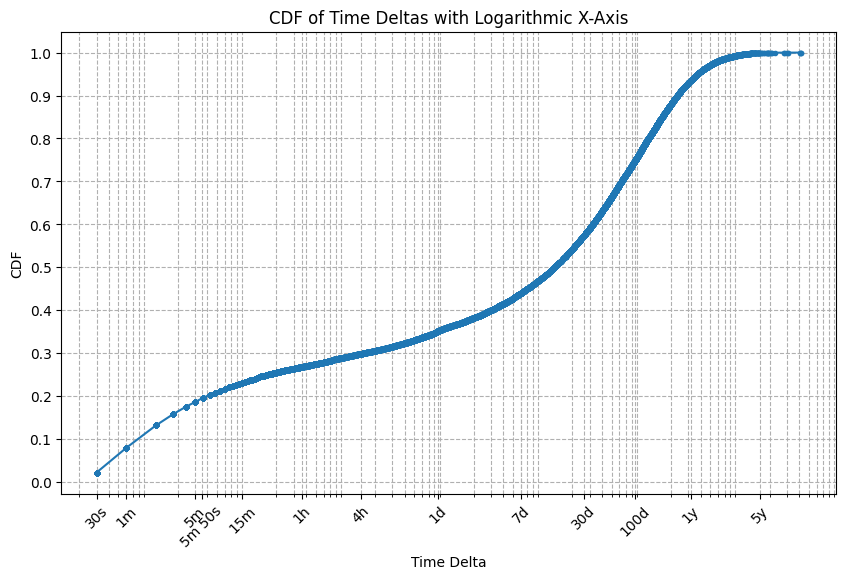

In [106]:
sorted_wait_series = lotto_waits.clip(lower=30) # for the plot, call 0 values 30 seconds
plt.figure(figsize=(10, 6))
plt.plot(sorted_wait_series, cdf, marker='.', linestyle='-')
plt.xlabel('Time Delta')
plt.ylabel('CDF')
plt.title('CDF of Time Deltas with Logarithmic X-Axis')
plt.xscale('log')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(wiki_wait_ticks, wait_tick_labels, rotation=45)
plt.grid(True, which="both", ls="--")
plt.show()


In [87]:
seconds_to_text(3600*4.5)

'4h 30m'